In [468]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/pytorch")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")

from turing.three_nodes_circuits import create_circuit_3954
from pde_solvers.cn import RD_2D_1st_Order, Neumann_Boundary_2D, Diritchlet_Boundary_2D,Periodic_Boundary_2D

from local_utils import *

from intro import *
from scipy.optimize import minimize

import pandas as pd

In [3]:
import pickle
with open(f"./inputs/solution_3.pkl", "rb") as f:
    (run_params, params, solution) = pickle.load(f)
    
    
run_params = Struct(**run_params)
params = Struct(**params)

In [ ]:
def p(* args):
    plot_n_im(args, 
           [chr(ord('A') + i) for i in range(28)][:len(args)],          
        figsize=(12, 3)); plt.tight_layout();plt.show()

In [987]:
def create_F_A(A,B,C):
    def F_A(b_A, mu_A, V_A,
            K_AA, K_BA, n, **kwargs):
        fA_v = b_A + V_A * act(A, K_AA, n) * inh(B, K_BA, n) - mu_A * A        
        return fA_v
    return F_A
def create_F_B(A,B,C):
    def F_B(b_B, mu_B, V_B,
            K_AB, K_CB, n, **kwargs):
        fB_v = b_B + V_B * act(A, K_AB, n) * inh(C, K_CB, n) - mu_B * B
        return fB_v
    return F_B
def create_F_C(A,B,C):
    def F_C(b_C, mu_C, V_C,
            K_AC, K_BC, K_CC, n, **kwargs):
        fC_v = b_C + V_C * inh(A, K_AC, n) * inh(B, K_BC, n) * act(C, K_CC, n) - mu_C * C        
        return fC_v
    return F_C
def create_F_C_no_mu_c(A,B,C):
    def F_C(b_C,  V_C,
            K_AC, K_BC, K_CC, n, **kwargs):
        fC_v = b_C + V_C * inh(A, K_AC, n) * inh(B, K_BC, n) * act(C, K_CC, n) - params["mu_C"] * C        
        return fC_v
    return F_C
def create_F_C_inv1(A,B,C):
    def F_C(b_C, mu_C, V_C,
            K_AC, K_BC, K_CC, n, **kwargs):
        fC_v = b_C/(mu_C + 1e-60) + (V_C/(mu_C + 1e-60)) * inh(A, K_AC, n) * inh(B, K_BC, n) * act(C, K_CC, n) -  C
        return fC_v
    return F_C

def create_F_C_inv2(A,B,C):
    def F_C(b_C, mu_C, V_C,
            K_AC, K_BC, K_CC, n, **kwargs):
        fC_v = 1 + (V_C/(b_C + 1e-60)) * inh(A, K_AC, n) * inh(B, K_BC, n) * act(C, K_CC, n) - (mu_C/(b_C + 1e-60)) * C
        return fC_v
    return F_C

def create_F_C_inv3(A,B,C):
    def F_C(b_C, mu_C, V_C,
            K_AC, K_BC, K_CC, n, **kwargs):
        fC_v = b_C/(V_C + 1e-60) + inh(A, K_AC, n) * inh(B, K_BC, n) * act(C, K_CC, n) - (mu_C/(V_C + 1e-60)) * C
        return fC_v
    return F_C

def create_param_kinetics(A,B,C):
    F_A = create_F_A(A,B,C)
    F_B = create_F_B(A,B,C)
    F_C = create_F_C(A,B,C)
    def circuit_3954(b_A, mu_A, V_A,
                     K_AA, K_AB, K_AC, 
                     b_B, mu_B, V_B, 
                     K_BA, K_BC, 
                     b_C, mu_C, V_C, 
                     K_CB, K_CC, n, **kwargs):
        fA_v = F_A(b_A, mu_A, V_A, K_AA, K_BA, n)
        fB_v = F_B(b_B, mu_B, V_B, K_AB, K_CB, n)
        fC_v = F_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n)
        return (fA_v, fB_v, fC_v)
    return circuit_3954

In [895]:
D_A, D_B , n, mu_C= 0.01, 1.0, 4, params["mu_C"]
model = RD_2D_1st_Order(Ds=[D_A, D_B, 0], 
                        delta_t=100/5000, 
                        Lx=10, Ly=10, 
                        Ix=128, Jy=128,
                        boundary_condition=Neumann_Boundary_2D)

/end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


In [230]:



kinetics = create_circuit_3954(params["n"],params["b_A"], params["mu_A"], params["V_A"], 
                                       params["K_AA"], params["K_AB"], params["K_AC"],
                                       params["b_B"], params["mu_B"], params["V_B"], 
                                       params["K_BA"], params["K_BC"],
                                       params["b_C"], params["mu_C"], params["V_C"], 
                                       params["K_CB"], params["K_CC"])

(A_init, B_init, C_init) = (solution[0, 0, :, :].flatten(),
                            solution[0, 1, :, :].flatten(),
                            solution[0, 2, :, :].flatten())
solution_test = model.integrate([A_init, B_init, C_init],kinetics, 40*5000, record_steps=1)

In [325]:
solution = solution_test

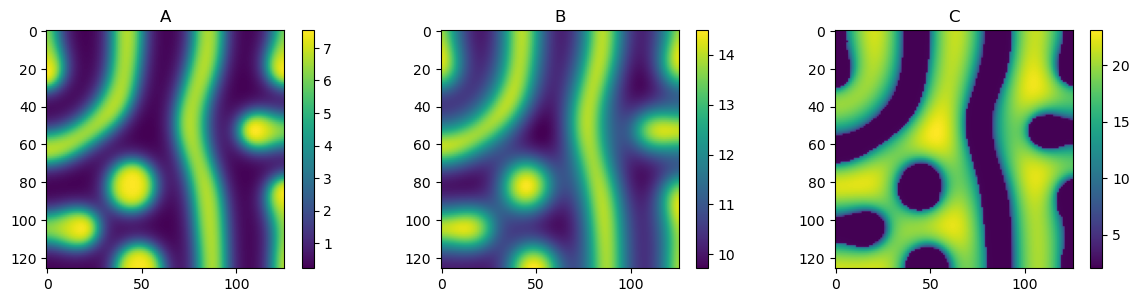

In [990]:
index = -1#5000#-2#200000-1#3000#5000-1
A_n = solution[index,0, :].reshape((128,128))
B_n = solution[index,1, :].reshape((128,128))
C_n = solution[index,2, :].reshape((128,128))

A_n_1 = solution[index-1,0, :].reshape((128,128))
B_n_1 = solution[index-1,1, :].reshape((128,128))
C_n_1 = solution[index-1,2, :].reshape((128,128))

x_slice = y_slice = slice(1,-1,1)
p(A_n[x_slice,y_slice], B_n[x_slice,y_slice], C_n[x_slice,y_slice])
diff_c = 1/(model.Δx*model.Δy)
diffusion_A_n = diff_c * grad_diff(A_n)[x_slice,y_slice]
diffusion_B_n = diff_c * grad_diff(B_n)[x_slice,y_slice]


param_F_A = create_F_A(A_n, B_n, C_n)
param_F_B = create_F_B(A_n, B_n, C_n)
param_F_C = create_F_C(A_n, B_n, C_n)

param_F_C_no_mu_C = create_F_C_no_mu_c(A_n, B_n, C_n)


param_F_C_inv1 = create_F_C_inv1(A_n, B_n, C_n)
param_F_C_inv2 = create_F_C_inv2(A_n, B_n, C_n)
param_F_C_inv3 = create_F_C_inv3(A_n, B_n, C_n)

D_A, D_B, n = params["D_A"], params["D_B"],params["n"]

def time_der_A(b_A, mu_A, V_A,
               K_AA, K_BA, **kwargs):
    
    F_A = param_F_A(b_A, mu_A, V_A, K_AA, K_BA, n)
    dAdt = D_A*diffusion_A_n + F_A[x_slice,y_slice]    
    return dAdt

def time_der_B(b_B, mu_B, V_B,
               K_AB, K_CB, **kwargs):
    
    F_B = param_F_B(b_B, mu_B, V_B, K_AB, K_CB, n)
    dBdt = D_B*diffusion_B_n + F_B[x_slice,y_slice]    
    return dBdt

def time_der_C(b_C, mu_C, V_C,
               K_AC, K_BC, K_CC, **kwargs):
    
    dCdt = param_F_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n)[x_slice,y_slice] 
    return dCdt
def time_der_C_with_no_mu_c(b_C, V_C,
               K_AC, K_BC, K_CC, **kwargs):
    
    dCdt = param_F_C_no_mu_C(b_C, V_C, K_AC, K_BC, K_CC, n)[x_slice,y_slice] 
    return dCdt
def time_der_C_with_inv(b_C, mu_C, V_C,
               K_AC, K_BC, K_CC, **kwargs):
    
    dCdt = param_F_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n)[x_slice,y_slice]
    dCdt_inv1 = param_F_C_inv1(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n)[x_slice,y_slice]
    dCdt_inv2 = param_F_C_inv2(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n)[x_slice,y_slice]
    dCdt_inv3 = param_F_C_inv3(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n)[x_slice,y_slice]
    return dCdt, dCdt_inv1, dCdt_inv2, dCdt_inv3

def time_derivatives(b_A, mu_A, V_A,
                     K_AA, K_AB, K_AC, 
                     b_B, mu_B, V_B, 
                     K_BA, K_BC, 
                     b_C, mu_C, V_C, 
                     K_CB, K_CC, **kwargs):
    
#     e = np.exp
#     F_A, F_B, F_C = param_kinetics(e(b_A), e(mu_A), e(V_A),
#                                    e(K_AA), e(K_AB), e(K_AC),
#                                    e(b_B), e(mu_B), e(V_B),
#                                    e(K_BA), e(K_BC),
#                                    e(b_C), e(mu_C), e(V_C), e(K_CB), e(K_CC), n)
    dAdt = time_der_A(b_A, mu_A, V_A, K_AA, K_BA)
    dBdt = time_der_B(b_B, mu_B, V_B, K_AB, K_CB)
    dCdt = time_der_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC)
    return dAdt, dBdt, dCdt

def loss_A(b_A, mu_A, V_A,K_AA, K_BA,  **kwargs):
    dAdt = time_der_A(b_A, mu_A, V_A, K_AA, K_BA)
    return np.mean(dAdt**2)

def loss_B(b_B, mu_B, V_B,K_AB, K_CB,  **kwargs):
    dBdt = time_der_B(b_B, mu_B, V_B, K_AB, K_CB)
    return np.mean(dBdt**2)

def loss_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC,  **kwargs):
    dCdt = time_der_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC)
    return np.mean(dCdt**2)

def loss(args,  **kwargs):
    (b_A, mu_A, V_A,
     K_AA, K_AB, K_AC, 
     b_B, mu_B, V_B, 
     K_BA, K_BC, 
     b_C, mu_C, V_C, 
     K_CB, K_CC) = args
    dAdt,dBdt,dCdt = time_derivatives(b_A, mu_A, V_A,K_AA, K_AB, K_AC,b_B, mu_B, V_B,K_BA, K_BC,
                                      b_C, mu_C, V_C, K_CB, K_CC)
    
    loss_A = np.mean(dAdt**2)
    loss_B = np.mean(dBdt**2)
    loss_C = np.mean(dCdt**2)
    return (loss_A + loss_B + loss_C)

def loss_no_mu_C(args,  **kwargs):
    (b_A, mu_A, V_A,
     K_AA, K_AB, K_AC, 
     b_B, mu_B, V_B, 
     K_BA, K_BC, 
     b_C, V_C, 
     K_CB, K_CC) = args
    dAdt = time_der_A(b_A, mu_A, V_A, K_AA, K_BA)
    dBdt = time_der_B(b_B, mu_B, V_B, K_AB, K_CB)
    dCdt = time_der_C_with_no_mu_c(b_C, V_C, K_AC, K_BC, K_CC)
    loss_A = np.mean(dAdt**2)
    loss_B = np.mean(dBdt**2)
    loss_C = np.mean(dCdt**2)
    return (loss_A + loss_B + loss_C)

    return (loss_A + loss_B + loss_C)

def loss_with_invs(args,  **kwargs):
    (b_A, mu_A, V_A,
     K_AA, K_AB, K_AC, 
     b_B, mu_B, V_B, 
     K_BA, K_BC, 
     b_C, mu_C, V_C, 
     K_CB, K_CC) = args
    dAdt = time_der_A(b_A, mu_A, V_A, K_AA, K_BA)
    dBdt = time_der_B(b_B, mu_B, V_B, K_AB, K_CB)
    dCdt, dCdt_inv1, dCdt_inv2, dCdt_inv3 = time_der_C_with_inv(b_C, mu_C, V_C, K_AC, K_BC, K_CC)
    loss_A = np.mean(dAdt**2)
    loss_B = np.mean(dBdt**2)
    loss_C = np.mean(dCdt**2)+np.mean(dCdt_inv1**2)+np.mean(dCdt_inv2**2)+np.mean(dCdt_inv3**2)
    return (loss_A + loss_B + loss_C)

params_A_name_list = ["b_A", "mu_A", "V_A","K_AA", "K_BA"]
params_B_name_list = ["b_B", "mu_B", "V_B","K_AB", "K_CB"]
params_C_name_list = ["b_C", "mu_C", "V_C","K_AC", "K_BC", "K_CC"]
params_name_list = ["b_A", "mu_A", "V_A","K_AA", "K_AB", "K_AC","b_B", "mu_B", "V_B","K_BA", "K_BC",
                    "b_C", "mu_C", "V_C", "K_CB", "K_CC"]

params_name_list_no_mu_C = ["b_A", "mu_A", "V_A","K_AA", "K_AB", "K_AC","b_B", "mu_B", "V_B","K_BA", "K_BC",
                    "b_C", "V_C", "K_CB", "K_CC"]

0.008294896940160716
0.02031946614358639
0.0001399698734918027 7.096621483837921e-05 0.008293412294029148
0.0001399698734918027 7.096621483837921e-05 0.008293412294029148
1.959156548531125e-08 5.036203648486994e-09 6.878068747875382e-05


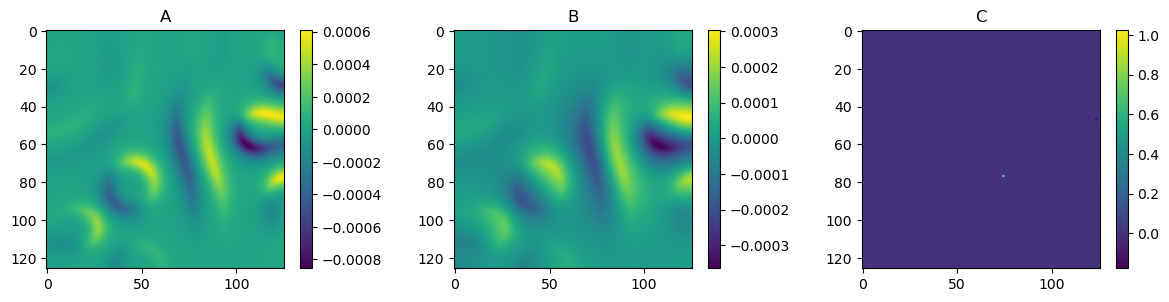

In [959]:
params_list = [params.b_A, params.mu_A, params.V_A, params.K_AA, params.K_AB, params.K_AC, 
               params.b_B, params.mu_B, params.V_B, params.K_BA, params.K_BC, 
               params.b_C, params.mu_C, params.V_C, params.K_CB, params.K_CC]
# params_log = [np.log(l) for l in params_list]
# print(np.sqrt(loss(params_log)))

# a,b,c = time_derivatives(*params_log)
# print(np.sqrt(np.mean(a**2)),np.sqrt(np.mean(b**2)),np.sqrt(np.mean(c**2)))
# p(a,b,c)

print(np.sqrt(loss(params_list)))
print(np.sqrt(loss_with_invs(params_list)))
a,b,c = time_derivatives(*params_list)
print(np.sqrt(np.mean(a**2)),np.sqrt(np.mean(b**2)),np.sqrt(np.mean(c**2)))

# 0.008260324969748052
#0.0001398658536897556, 6.759127670819233e-05, 0.008258864181479664
a2 = loss_A(params.b_A, params.mu_A, params.V_A, params.K_AA, params.K_BA)
b2 = loss_B(params.b_B, params.mu_B, params.V_B, params.K_AB, params.K_CB)
c2 = loss_C(params.b_C, params.mu_C, params.V_C, params.K_AC, params.K_BC, params.K_CC)
print(np.sqrt(a2),np.sqrt(b2),np.sqrt(c2))

print(a2,b2,c2)

p(a,b,c)

In [989]:
A_min, A_max = np.min(A_n), np.max(A_n)
B_min, B_max = np.min(B_n), np.max(B_n)
C_min, C_max = np.min(C_n), np.max(C_n)
tol = .005

def define_bound(tol, n, x_min, x_max):
    upper = ((1-tol)/tol)**(1/n)
    lower = (tol/(1-tol))**(1/n)
    # return (lower, upper) bounds and the initial guess
    return (max(0,x_min*lower), x_max*upper), max(0, (x_max*upper-max(0,x_min*lower))/2)
    
K_AA_bound, K_AA_init =  define_bound(tol, n, A_min, A_max)
K_AB_bound, K_AB_init =  define_bound(tol, n, A_min, A_max)
K_AC_bound, K_AC_init =  define_bound(tol, n, A_min, A_max)
K_BA_bound, K_BA_init =  define_bound(tol, n, B_min, B_max)
K_BC_bound, K_BC_init =  define_bound(tol, n, B_min, B_max)
K_CB_bound, K_CB_init =  define_bound(tol, n, C_min, C_max)
K_CC_bound, K_CC_init =  define_bound(tol, n, C_min, C_max)

In [906]:
i = 0
def print_callback(x):
    global i
    
    if (i+1)%100 == 0 or i == 0:
        print(f"iteration:{i+1}, loss: {loss(x):.8f} ", 
          f", ".join([f"{name}={l:.4f}" 
                 for l, name in zip(x, params_name_list)]))
    i += 1
    
# init_params = [params.b_A, params.mu_A, params.V_A, params.K_AA, params.K_AB, params.K_AC, 
#                params.b_B, params.mu_B, params.V_B, params.K_BA, params.K_BC, 
#                params.b_C, params.mu_C, params.V_C, params.K_CB, params.K_CC]
init_params = [1, 1, 1, K_AA_init, K_AB_init, K_AC_init, 
               1, 1, 1, K_BA_init, K_BC_init, 
               1, 1, 1, K_CB_init, K_CC_init]


#bounds = [ (0, None) for _ in init_params]
bounds = [ (0, None), (0, None), (0, None), K_AA_bound, K_AC_bound, K_AC_bound,
           (0, None), (0, None), (0, None), K_BA_bound, K_BC_bound,
           (0, None), (0, None), (0, None), K_CB_bound, K_CC_bound]
res = minimize(loss, init_params, bounds=bounds, tol=1e-16,
               options={'maxiter':2000, 'maxfun':50000},
               method="L-BFGS-B",#"Powell",#"Nelder-Mead",# 
               callback=print_callback)
estimated_params = dict()
for l, name in zip(res.x, params_name_list):    
    estimated_params[name] = l#np.exp(l)
print("\n\n\n")
# i = 0
# res_unbound = minimize(loss, init_params, 
#                options={'maxiter':1000},tol=1e-16,
#                method="L-BFGS-B",#"Powell",#"Nelder-Mead",# 
#                callback=print_callback)
# estimated_params_unbound = dict()
# for l, name in zip(res_unbound.x, params_name_list):    
#     estimated_params_unbound[name] = l#np.exp(l)

iteration:1, loss: 154.37225248  b_A=1.6177, mu_A=0.8428, V_A=1.0179, K_AA=14.1385, K_AB=14.1233, K_AC=14.1433, b_B=4.3745, mu_B=0.8428, V_B=1.0739, K_BA=25.9816, K_BC=25.9819, b_C=4.6244, mu_C=0.8428, V_C=1.1213, K_CB=43.0987, K_CC=43.0879
iteration:100, loss: 0.00891067  b_A=0.0000, mu_A=0.0163, V_A=4.4468, K_AA=12.4695, K_AB=4.9972, K_AC=14.1435, b_B=0.9280, mu_B=0.4929, V_B=19.9536, K_BA=26.0386, K_BC=25.9804, b_C=0.0050, mu_C=0.0013, V_C=0.5499, K_CB=43.1062, K_CC=43.1320
iteration:200, loss: 0.00086500  b_A=0.0127, mu_A=0.1140, V_A=1.1851, K_AA=4.2285, K_AB=4.9972, K_AC=14.1445, b_B=0.9378, mu_B=0.4939, V_B=19.9575, K_BA=23.6060, K_BC=25.9689, b_C=0.0000, mu_C=0.0000, V_C=0.0000, K_CB=43.7834, K_CC=43.5991
iteration:300, loss: 0.00011088  b_A=0.0108, mu_A=0.1075, V_A=2.7726, K_AA=4.7161, K_AB=5.0019, K_AC=14.1449, b_B=0.9415, mu_B=0.4943, V_B=19.9854, K_BA=12.2875, K_BC=25.9617, b_C=0.0000, mu_C=0.0000, V_C=0.0000, K_CB=45.5445, K_CC=43.8976
iteration:400, loss: 0.00002109  b_A=0

In [907]:
res#, res_unbound

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 4.76895480586184e-08
        x: [ 9.957e-04  9.999e-02 ...  8.674e+01  4.394e+01]
      nit: 1181
      jac: [ 9.664e-07  3.352e-08 ... -4.943e-09  0.000e+00]
     nfev: 23749
     njev: 1397
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>

In [908]:
Ks_bounds = {"K_AA":K_AA_bound, 
             "K_AB":K_AB_bound, 
             "K_AC":K_AC_bound,
             "K_BA":K_BA_bound, 
             "K_BC":K_BC_bound,
             "K_CB":K_CB_bound, 
             "K_CC": K_CC_bound}
def closest_bound(name, v):
    if not name.startswith("K"):
        return np.nan
    lower, upper = Ks_bounds[name]
    if np.abs(v-lower) < np.abs(v-upper):
        return lower
    else:
        return upper 
def get_bound(name):
    if not name.startswith("K"):
        return (np.nan,np.nan)
    return Ks_bounds[name]

print("name \tOriginl \tEstimated \tClosest Bound \tBounds")# \tEstimated (Unbounded)")
print("------------------------------------------------------------------------------")
print("\n".join([ f"{name}:\t{params[name]:.3f}\t\t"                  
                  f"{estimated_params[name]:.3f}\t\t"
                  f"{closest_bound(name, estimated_params[name]):.3f}\t\t"
                  f"({get_bound(name)[0]:.3f},{get_bound(name)[1]:.3f})"
                 #f"{estimated_params_unbound[name]:.3f}\t\t"
      for name in params_name_list
]))

name 	Originl 	Estimated 	Closest Bound 	Bounds
------------------------------------------------------------------------------
b_A:	0.001		0.001		nan		(nan,nan)
mu_A:	0.100		0.100		nan		(nan,nan)
V_A:	5.000		5.002		nan		(nan,nan)
K_AA:	5.000		5.000		0.061		(0.061,28.348)
K_AB:	5.000		5.000		0.061		(0.061,28.348)
K_AC:	5.000		14.145		0.061		(0.061,28.348)
b_B:	1.000		0.998		nan		(nan,nan)
mu_B:	0.500		0.500		nan		(nan,nan)
V_B:	20.000		19.999		nan		(nan,nan)
K_BA:	10.000		9.998		2.588		(2.588,54.550)
K_BC:	10.000		25.961		2.588		(2.588,54.550)
b_C:	1.000		0.000		nan		(nan,nan)
mu_C:	0.500		0.000		nan		(nan,nan)
V_C:	20.000		0.000		nan		(nan,nan)
K_CB:	100.000		86.738		86.738		(0.541,86.738)
K_CC:	5.000		43.938		86.738		(0.541,86.738)


In [1025]:
A_min, A_max = np.min(A_n), np.max(A_n)
B_min, B_max = np.min(B_n), np.max(B_n)
C_min, C_max = np.min(C_n), np.max(C_n)
tol = .005

def define_bound(tol, n, x_min, x_max):
    upper = ((1-tol)/tol)**(1/n)
    lower = (tol/(1-tol))**(1/n)
    # return (lower, upper) bounds and the initial guess
    return (max(0,x_min*lower), x_max*upper), max(0, (x_max*upper-max(0,x_min*lower))/2)
    
K_AA_bound, K_AA_init =  define_bound(tol, n, A_min, A_max)
K_AB_bound, K_AB_init =  define_bound(tol, n, A_min, A_max)
K_AC_bound, K_AC_init =  define_bound(tol, n, A_min, A_max)
K_BA_bound, K_BA_init =  define_bound(tol, n, B_min, B_max)
K_BC_bound, K_BC_init =  define_bound(tol, n, B_min, B_max)
K_CB_bound, K_CB_init =  define_bound(tol, n, C_min, C_max)
K_CC_bound, K_CC_init =  define_bound(tol, n, C_min, C_max)

In [1026]:
K_CB_bound, K_CB_init, K_CC_bound, K_CC_init

((0.5410640574816339, 86.73846524951207),
 43.09870059601522,
 (0.5410640574816339, 86.73846524951207),
 43.09870059601522)

In [1031]:

i = 0
def print_callback(x):
    global i
    
    if (i+1)%100 == 0 or i == 0:
        print(f"iteration:{i+1}, loss: {loss_no_mu_C(x):.8f} ", 
          f", ".join([f"{name}={l:.4f}" 
                 for l, name in zip(x, params_name_list_no_mu_C)]))
    i += 1
    
# init_params = [params.b_A, params.mu_A, params.V_A, params.K_AA, params.K_AB, params.K_AC, 
#                params.b_B, params.mu_B, params.V_B, params.K_BA, params.K_BC, 
#                params.b_C,  params.V_C, params.K_CB, params.K_CC]
init_params = [1, 1, 1, K_AA_init, K_AB_init, K_AC_init, 
               1, 1, 1, K_BA_init, K_BC_init, 
               1, 1,  K_CB_init, K_CC_init]


bounds = [ (0, None) for _ in init_params]
# bounds = [ (0, None), (0, None), (0, None), K_AA_bound, K_AC_bound, K_AC_bound,
#            (0, None), (0, None), (0, None), K_BA_bound, K_BC_bound,
#            (0, None), (0, None), K_CB_bound, K_CC_bound]
res = minimize(loss_no_mu_C, init_params, bounds=bounds, tol=1e-16,
               options={'maxiter':1e4, 'maxfun':1e6},
               method="L-BFGS-B",#"Powell",#"Nelder-Mead",# 
               callback=print_callback)
estimated_params = dict()
for l, name in zip(res.x, params_name_list_no_mu_C):    
    estimated_params[name] = l#np.exp(l)


iteration:1, loss: 177.28066306  b_A=1.1619, mu_A=0.9588, V_A=1.0047, K_AA=14.1420, K_AB=14.1381, K_AC=14.1433, b_B=1.8845, mu_B=0.9588, V_B=1.0194, K_BA=25.9814, K_BC=25.9815, b_C=1.4329, V_C=1.0150, K_CB=43.0987, K_CC=43.0974
iteration:100, loss: 0.15422577  b_A=0.0000, mu_A=0.0071, V_A=3.7544, K_AA=12.8325, K_AB=4.9699, K_AC=14.9081, b_B=1.7590, mu_B=0.5703, V_B=20.1210, K_BA=26.0267, K_BC=26.8786, b_C=1.1753, V_C=10.4168, K_CB=43.1667, K_CC=12.6731
iteration:200, loss: 0.12818829  b_A=0.0000, mu_A=0.0352, V_A=6.3176, K_AA=12.3852, K_AB=4.9434, K_AC=17.5129, b_B=2.0742, mu_B=0.6014, V_B=20.2337, K_BA=25.8693, K_BC=17.1564, b_C=1.2006, V_C=11.0249, K_CB=43.2086, K_CC=11.6957
iteration:300, loss: 0.02798178  b_A=0.0000, mu_A=0.0117, V_A=30.9559, K_AA=21.2218, K_AB=5.0153, K_AC=18.4565, b_B=0.7213, mu_B=0.4737, V_B=19.9787, K_BA=25.2465, K_BC=10.0725, b_C=1.0649, V_C=20.0659, K_CB=43.2260, K_CC=8.5041
iteration:400, loss: 0.02763758  b_A=0.0000, mu_A=0.0122, V_A=13.7459, K_AA=17.1778, 

iteration:3700, loss: 0.00006878  b_A=0.0003, mu_A=0.0992, V_A=5.4832, K_AA=5.0275, K_AB=4.9998, K_AC=5.0046, b_B=0.9960, mu_B=0.4996, V_B=19.9974, K_BA=9.7123, K_BC=9.9989, b_C=1.0010, V_C=20.0038, K_CB=78.9306, K_CC=5.0243
iteration:3800, loss: 0.00006877  b_A=0.0004, mu_A=0.0993, V_A=5.4855, K_AA=5.0271, K_AB=4.9998, K_AC=5.0046, b_B=0.9968, mu_B=0.4997, V_B=19.9977, K_BA=9.7132, K_BC=9.9989, b_C=1.0010, V_C=20.0039, K_CB=79.3871, K_CC=5.0242
iteration:3900, loss: 0.00006875  b_A=0.0004, mu_A=0.0993, V_A=5.4775, K_AA=5.0262, K_AB=4.9999, K_AC=5.0045, b_B=0.9947, mu_B=0.4995, V_B=19.9972, K_BA=9.7173, K_BC=9.9999, b_C=1.0011, V_C=19.9993, K_CB=80.6326, K_CC=5.0251
iteration:4000, loss: 0.00006869  b_A=0.0004, mu_A=0.0993, V_A=5.4559, K_AA=5.0262, K_AB=4.9998, K_AC=5.0039, b_B=0.9990, mu_B=0.4999, V_B=19.9984, K_BA=9.7288, K_BC=10.0010, b_C=1.0010, V_C=19.9943, K_CB=84.3624, K_CC=5.0236
iteration:4100, loss: 0.00006839  b_A=0.0008, mu_A=0.0999, V_A=5.2556, K_AA=5.0086, K_AB=5.0001, K_

In [1032]:
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 6.798432438623928e-05
        x: [ 9.905e-04  9.999e-02 ...  1.525e+02  5.024e+00]
      nit: 4910
      jac: [-5.830e-07  1.020e-06 ...  3.266e-10 -1.524e-08]
     nfev: 90336
     njev: 5646
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>

In [1033]:
Ks_bounds = {"K_AA":K_AA_bound, 
             "K_AB":K_AB_bound, 
             "K_AC":K_AC_bound,
             "K_BA":K_BA_bound, 
             "K_BC":K_BC_bound,
             "K_CB":K_CB_bound, 
             "K_CC": K_CC_bound}
def closest_bound(name, v):
    if not name.startswith("K"):
        return np.nan
    lower, upper = Ks_bounds[name]
    if np.abs(v-lower) < np.abs(v-upper):
        return lower
    else:
        return upper 
def get_bound(name):
    if not name.startswith("K"):
        return (np.nan,np.nan)
    return Ks_bounds[name]

print("name \tOriginl \tEstimated \tClosest Bound \tBounds")# \tEstimated (Unbounded)")
print("------------------------------------------------------------------------------")
print("\n".join([ f"{name}:\t{params[name]:.3f}\t\t"                  
                  f"{estimated_params[name]:.3f}\t\t"
                  f"{closest_bound(name, estimated_params[name]):.3f}\t\t"
                  f"({get_bound(name)[0]:.3f},{get_bound(name)[1]:.3f})"
                 #f"{estimated_params_unbound[name]:.3f}\t\t"
      for name in params_name_list_no_mu_C
]))

name 	Originl 	Estimated 	Closest Bound 	Bounds
------------------------------------------------------------------------------
b_A:	0.001		0.001		nan		(nan,nan)
mu_A:	0.100		0.100		nan		(nan,nan)
V_A:	5.000		5.008		nan		(nan,nan)
K_AA:	5.000		5.000		0.061		(0.061,28.348)
K_AB:	5.000		5.000		0.061		(0.061,28.348)
K_AC:	5.000		5.005		0.061		(0.061,28.348)
b_B:	1.000		1.002		nan		(nan,nan)
mu_B:	0.500		0.500		nan		(nan,nan)
V_B:	20.000		20.001		nan		(nan,nan)
K_BA:	10.000		9.995		2.588		(2.588,54.550)
K_BC:	10.000		9.999		2.588		(2.588,54.550)
b_C:	1.000		1.001		nan		(nan,nan)
V_C:	20.000		20.003		nan		(nan,nan)
K_CB:	100.000		152.495		86.738		(0.541,86.738)
K_CC:	5.000		5.024		0.541		(0.541,86.738)


In [1030]:
Ks_bounds = {"K_AA":K_AA_bound, 
             "K_AB":K_AB_bound, 
             "K_AC":K_AC_bound,
             "K_BA":K_BA_bound, 
             "K_BC":K_BC_bound,
             "K_CB":K_CB_bound, 
             "K_CC": K_CC_bound}
def closest_bound(name, v):
    if not name.startswith("K"):
        return np.nan
    lower, upper = Ks_bounds[name]
    if np.abs(v-lower) < np.abs(v-upper):
        return lower
    else:
        return upper 
def get_bound(name):
    if not name.startswith("K"):
        return (np.nan,np.nan)
    return Ks_bounds[name]

print("name \tOriginl \tEstimated \tClosest Bound \tBounds")# \tEstimated (Unbounded)")
print("------------------------------------------------------------------------------")
print("\n".join([ f"{name}:\t{params[name]:.3f}\t\t"                  
                  f"{estimated_params[name]:.3f}\t\t"
                  f"{closest_bound(name, estimated_params[name]):.3f}\t\t"
                  f"({get_bound(name)[0]:.3f},{get_bound(name)[1]:.3f})"
                 #f"{estimated_params_unbound[name]:.3f}\t\t"
      for name in params_name_list_no_mu_C
]))

name 	Originl 	Estimated 	Closest Bound 	Bounds
------------------------------------------------------------------------------
b_A:	0.001		0.001		nan		(nan,nan)
mu_A:	0.100		0.100		nan		(nan,nan)
V_A:	5.000		5.000		nan		(nan,nan)
K_AA:	5.000		5.000		0.061		(0.061,28.348)
K_AB:	5.000		5.000		0.061		(0.061,28.348)
K_AC:	5.000		5.005		0.061		(0.061,28.348)
b_B:	1.000		0.998		nan		(nan,nan)
mu_B:	0.500		0.500		nan		(nan,nan)
V_B:	20.000		19.999		nan		(nan,nan)
K_BA:	10.000		10.000		2.588		(2.588,54.550)
K_BC:	10.000		9.999		2.588		(2.588,54.550)
b_C:	1.000		1.001		nan		(nan,nan)
V_C:	20.000		20.003		nan		(nan,nan)
K_CB:	100.000		86.738		86.738		(0.541,86.738)
K_CC:	5.000		5.024		0.541		(0.541,86.738)


In [960]:
A_min, A_max = np.min(A_n), np.max(A_n)
B_min, B_max = np.min(B_n), np.max(B_n)
C_min, C_max = np.min(C_n), np.max(C_n)
tol = .005

def define_bound(tol, n, x_min, x_max):
    upper = ((1-tol)/tol)**(1/n)
    lower = (tol/(1-tol))**(1/n)
    # return (lower, upper) bounds and the initial guess
    return (max(0,x_min*lower), x_max*upper), max(0, (x_max*upper-max(0,x_min*lower))/2)
    
K_AA_bound, K_AA_init =  define_bound(tol, n, A_min, A_max)
K_AB_bound, K_AB_init =  define_bound(tol, n, A_min, A_max)
K_AC_bound, K_AC_init =  define_bound(tol, n, A_min, A_max)
K_BA_bound, K_BA_init =  define_bound(tol, n, B_min, B_max)
K_BC_bound, K_BC_init =  define_bound(tol, n, B_min, B_max)
K_CB_bound, K_CB_init =  define_bound(tol, n, C_min, C_max)
K_CC_bound, K_CC_init =  define_bound(tol, n, C_min, C_max)

In [961]:
K_AA_bound,K_AA_init, K_BA_bound,K_BA_init

((0.06114144985105499, 28.347762558270198),
 14.143310554209572,
 (2.5875577488427273, 54.55034190019611),
 25.98139207567669)

In [983]:
init_A_params = [1, 1, 1, K_AA_init, K_BA_init]#[params.b_A, params.mu_A, params.V_A, params.K_AA, params.K_BA]#
init_B_params = [1, 1, 1, K_AB_init, K_CB_init]#[params.b_B, params.mu_B, params.V_B, params.K_AB, params.K_CB]#[1, 1, 1, 1, 1]#[params.b_B, params.mu_B, params.V_B, params.K_AB, params.K_CB]#
init_C_params = [1, 1, 1, K_AC_init, K_BC_init, K_CC_init]#[params.b_C, params.mu_C, params.V_C, params.K_AC, params.K_BC, params.K_CC]#[1, 1, 1, 1, 1, 1]#

def change_by(it, scale=1.1):
    return [item*scale for item in it]

#init_A_params = change_by(init_A_params, scale=10)
#init_B_params = change_by(init_B_params, scale=2.2)
#init_C_params = change_by(init_C_params, scale=2.2)

iA = 0
def print_callbackA(x):
    global iA    
    if (iA+1)%1 == 0 or iA == 0:
        print(f"iteration:{iA+1}, loss: {loss_A(*x):.8f} ", 
          f", ".join([f"{name}={l:.4f}" 
                 for l, name in zip(x, params_A_name_list)]))
    iA += 1
iB = 0
def print_callbackB(x):
    global iB    
    if (iB+1)%1 == 0 or iB == 0:
        print(f"iteration:{iB+1}, loss: {loss_B(*x):.8f} ", 
          f", ".join([f"{name}={l:.4f}" 
                 for l, name in zip(x, params_B_name_list)]))
    iB += 1
iC = 0
def print_callbackC(x):
    global iC    
    if (iC+1)%1 == 0 or iC == 0:
        print(f"iteration:{iC+1}, loss: {loss_C(*x):.8f} ", 
          f", ".join([f"{name}={l:.4f}" 
                 for l, name in zip(x, params_C_name_list)]))
    iC += 1    

loss_A_helper = lambda args: loss_A(*args)#[0]
loss_B_helper = lambda args: loss_B(*args)#[0]
loss_C_helper = lambda args: loss_C(*args)#[0]

def loss_C_helper2(args):
    dCdt, dCdt_inv1, dCdt_inv2, dCdt_inv3 = time_der_C_with_inv(*args)
    #loss_C = np.mean(dCdt**2)+np.mean(dCdt_inv1**2)+np.mean(dCdt_inv2**2)+np.mean(dCdt_inv3**2)
    loss_C = np.mean(dCdt**2)+np.mean(dCdt_inv1**2)+np.mean(dCdt_inv2**2)
    return loss_C
    

bounds_A = [ (0, None) for _ in init_A_params[:3]] + [K_AA_bound, K_BA_bound]
resA = minimize(loss_A_helper, init_A_params, bounds=bounds_A,tol=1e-16,
               options={'maxiter':1000},
               method="L-BFGS-B",#"Powell",##"Nelder-Mead",# 
               callback=print_callbackA)
estimated_A_params = dict()
for l, name in zip(resA.x, params_A_name_list):    
    estimated_A_params[name] = l#np.exp(l)
print("\n\n\n")
bounds_B = [ (0, None) for _ in init_B_params[:3]] + [K_AB_bound, K_CB_bound]
resB = minimize(loss_B_helper, init_B_params, bounds=bounds_B,tol=1e-16,
               options={'maxiter':1000},
               method="L-BFGS-B",#"Powell",#"Nelder-Mead",# 
               callback=print_callbackB)
estimated_B_params = dict()
for l, name in zip(resB.x, params_B_name_list):    
    estimated_B_params[name] = l#np.exp(l)
print("\n\n\n")
bounds_C = [ (0, None) for _ in init_C_params[:3]] + [K_AC_bound, K_BC_bound, K_CC_bound]
resC = minimize(loss_C_helper2, init_C_params, bounds=bounds_C,tol=1e-16,
               options={'maxiter':1000},
               method="L-BFGS-B",#"Powell",#"Nelder-Mead",# 
               callback=print_callbackC)
estimated_C_params = dict()
for l, name in zip(resC.x, params_C_name_list):    
    estimated_C_params[name] = l#np.exp(l)
print("\n\n\n")

iteration:1, loss: 3.45108536  b_A=1.9687, mu_A=0.7534, V_A=1.0281, K_AA=14.1357, K_BA=25.9817
iteration:2, loss: 2.12335006  b_A=2.1056, mu_A=0.5558, V_A=1.0345, K_AA=14.1339, K_BA=25.9818
iteration:3, loss: 1.40802950  b_A=1.7891, mu_A=0.3926, V_A=1.0290, K_AA=14.1354, K_BA=25.9817
iteration:4, loss: 0.30807897  b_A=0.6617, mu_A=0.0574, V_A=1.0056, K_AA=14.1417, K_BA=25.9815
iteration:5, loss: 0.01388037  b_A=0.0000, mu_A=0.0000, V_A=0.9893, K_AA=14.1461, K_BA=25.9813
iteration:6, loss: 0.01108954  b_A=0.0000, mu_A=0.0000, V_A=2.1524, K_AA=13.8330, K_BA=25.9931
iteration:7, loss: 0.00957369  b_A=0.0000, mu_A=0.0000, V_A=3.5007, K_AA=13.4701, K_BA=26.0068
iteration:8, loss: 0.00935176  b_A=0.0000, mu_A=0.0030, V_A=4.0047, K_AA=13.3344, K_BA=26.0119
iteration:9, loss: 0.00899012  b_A=0.0000, mu_A=0.0124, V_A=5.0380, K_AA=13.0563, K_BA=26.0223
iteration:10, loss: 0.00891397  b_A=0.0000, mu_A=0.0147, V_A=5.0430, K_AA=13.0551, K_BA=26.0224
iteration:11, loss: 0.00891253  b_A=0.0000, mu_A=

iteration:31, loss: 0.00004266  b_B=0.9747, mu_B=0.4974, V_B=19.9489, K_AB=4.9931, K_CB=43.0971
iteration:32, loss: 0.00003204  b_B=0.9453, mu_B=0.4947, V_B=19.9581, K_AB=4.9964, K_CB=43.0972
iteration:33, loss: 0.00003151  b_B=0.9410, mu_B=0.4942, V_B=19.9554, K_AB=4.9963, K_CB=43.0972
iteration:34, loss: 0.00003127  b_B=0.9313, mu_B=0.4933, V_B=19.9541, K_AB=4.9967, K_CB=43.0972
iteration:35, loss: 0.00003115  b_B=0.9344, mu_B=0.4935, V_B=19.9560, K_AB=4.9975, K_CB=43.0972
iteration:36, loss: 0.00003099  b_B=0.9321, mu_B=0.4933, V_B=19.9548, K_AB=4.9972, K_CB=43.0972
iteration:37, loss: 0.00003099  b_B=0.9322, mu_B=0.4933, V_B=19.9548, K_AB=4.9972, K_CB=43.0973
iteration:38, loss: 0.00003099  b_B=0.9323, mu_B=0.4933, V_B=19.9549, K_AB=4.9972, K_CB=43.0973
iteration:39, loss: 0.00003099  b_B=0.9326, mu_B=0.4934, V_B=19.9550, K_AB=4.9972, K_CB=43.0975
iteration:40, loss: 0.00003099  b_B=0.9330, mu_B=0.4934, V_B=19.9552, K_AB=4.9972, K_CB=43.0981
iteration:41, loss: 0.00003098  b_B=0.93

In [984]:
resA, resB, resC# 1.95918160303455e-08 5.036268263885458e-09 6.820883756812898e-05

(  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
   success: True
    status: 0
       fun: 1.955948915348151e-08
         x: [ 9.995e-04  1.000e-01  5.003e+00  5.000e+00  9.998e+00]
       nit: 107
       jac: [ 8.898e-10 -1.133e-08  3.046e-10 -6.617e-10  4.611e-10]
      nfev: 972
      njev: 162
  hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>,
   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
   success: True
    status: 0
       fun: 2.812200432389668e-08
         x: [ 9.982e-01  4.998e-01  2.000e+01  5.000e+00  8.674e+01]
       nit: 73
       jac: [ 3.833e-08 -9.184e-07  1.429e-07 -5.856e-07 -4.951e-09]
      nfev: 666
      njev: 111
  hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>,
   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
   success: True
    status: 0
       fun: 33.04625365827811
         x: [ 3.380e-02  3.002e-03  8.245e-01  1.414e+01  2.598e+01
              4.311e+01]
       nit: 10
       jac: [ 2.983e+03 -4.556e+04

In [985]:
dCdt, dCdt_inv1, dCdt_inv2, dCdt_inv3 = time_der_C_with_inv(*resC.x)
loss_Cv = np.mean(dCdt**2)+np.mean(dCdt_inv1**2)+np.mean(dCdt_inv2**2)+np.mean(dCdt_inv3**2)
loss_Cv, np.mean(dCdt**2),np.mean(dCdt_inv1**2),np.mean(dCdt_inv2**2),np.mean(dCdt_inv3**2)    

(33.046688308942436,
 0.0002955065460718821,
 32.78736576538145,
 0.2585923863505839,
 0.0004346506643269177)

In [986]:
print("name \tOriginl \tEstimated ")
print("-------------------------------------------------------------------------------------------------------------")
print("\n".join([ f"{name}:\t{params[name]:.3f}\t\t"                  
                  f"{estimated_A_params[name]:.3f}\t\t"
      for name in params_A_name_list
]))
print("\n".join([ f"{name}:\t{params[name]:.3f}\t\t"                  
                  f"{estimated_B_params[name]:.3f}\t\t"
      for name in params_B_name_list
]))
print("\n".join([ f"{name}:\t{params[name]:.3f}\t\t"                  
                  f"{estimated_C_params[name]:.3f}\t\t"
      for name in params_C_name_list
]))

name 	Originl 	Estimated 
-------------------------------------------------------------------------------------------------------------
b_A:	0.001		0.001		
mu_A:	0.100		0.100		
V_A:	5.000		5.003		
K_AA:	5.000		5.000		
K_BA:	10.000		9.998		
b_B:	1.000		0.998		
mu_B:	0.500		0.500		
V_B:	20.000		19.999		
K_AB:	5.000		5.000		
K_CB:	100.000		86.738		
b_C:	1.000		0.034		
mu_C:	0.500		0.003		
V_C:	20.000		0.825		
K_AC:	5.000		14.143		
K_BC:	10.000		25.981		
K_CC:	5.000		43.114		


In [925]:
loss_C(*resC.x), loss_C(1,.5,20,5,10,5)

(6.283792892213134e-05, 6.878068747875382e-05)

In [570]:
index = -1#5000#-2#200000-1#3000#5000-1
A_n = solution[index,0, :].reshape((128,128))
B_n = solution[index,1, :].reshape((128,128))
C_n = solution[index,2, :].reshape((128,128))

x_slice = y_slice = slice(1,-1,1)

diff_c = 1/(model.Δx*model.Δy)
diffusion_A_n = diff_c * grad_diff(A_n)[x_slice,y_slice, np.newaxis, np.newaxis]
diffusion_B_n = diff_c * grad_diff(B_n)[x_slice,y_slice, np.newaxis, np.newaxis]


param_F_A = create_F_A(A_n[:,:, np.newaxis, np.newaxis], B_n[:,:, np.newaxis, np.newaxis], C_n[:,:, np.newaxis, np.newaxis])
param_F_B = create_F_B(A_n[:,:, np.newaxis, np.newaxis], B_n[:,:, np.newaxis, np.newaxis], C_n[:,:, np.newaxis, np.newaxis])
param_F_C = create_F_C(A_n[:,:, np.newaxis, np.newaxis], B_n[:,:, np.newaxis, np.newaxis], C_n[:,:, np.newaxis, np.newaxis])

D_A, D_B, n = params["D_A"], params["D_B"],params["n"]

def time_der_A(b_A, mu_A, V_A,
               K_AA, K_BA, **kwargs):
    
    F_A = param_F_A(b_A, mu_A, V_A, K_AA, K_BA, n)    
    dAdt = D_A*diffusion_A_n + F_A[x_slice,y_slice, :, :]    
    return dAdt

def time_der_B(b_B, mu_B, V_B,
               K_AB, K_CB, **kwargs):
    
    F_B = param_F_B(b_B, mu_B, V_B, K_AB, K_CB, n)
    dBdt = D_B*diffusion_B_n + F_B[x_slice,y_slice, :, :]    
    return dBdt

def time_der_C(b_C, mu_C, V_C,
               K_AC, K_BC, K_CC, **kwargs):
    
    dCdt = param_F_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n)[x_slice,y_slice, :, :] 
    return dCdt

def time_derivatives(b_A, mu_A, V_A,
                     K_AA, K_AB, K_AC, 
                     b_B, mu_B, V_B, 
                     K_BA, K_BC, 
                     b_C, mu_C, V_C, 
                     K_CB, K_CC, **kwargs):
    
#     e = np.exp
#     F_A, F_B, F_C = param_kinetics(e(b_A), e(mu_A), e(V_A),
#                                    e(K_AA), e(K_AB), e(K_AC),
#                                    e(b_B), e(mu_B), e(V_B),
#                                    e(K_BA), e(K_BC),
#                                    e(b_C), e(mu_C), e(V_C), e(K_CB), e(K_CC), n)
    dAdt = time_der_A(b_A, mu_A, V_A, K_AA, K_BA)
    dBdt = time_der_B(b_B, mu_B, V_B, K_AB, K_CB)
    dCdt = time_der_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC)
    return dAdt, dBdt, dCdt

def loss_A(b_A, mu_A, V_A,K_AA, K_BA,  **kwargs):
    dAdt = time_der_A(b_A, mu_A, V_A, K_AA, K_BA)  
    return np.mean(dAdt**2, axis=(0,1))

def loss_B(b_B, mu_B, V_B,K_AB, K_CB,  **kwargs):
    dBdt = time_der_B(b_B, mu_B, V_B, K_AB, K_CB)
    return np.mean(dBdt**2, axis=(0,1))

def loss_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC,  **kwargs):
    dCdt = time_der_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC)
    return np.mean(dCdt**2, axis=(0,1))

In [597]:
loss_A(b_A=0.01, 
       **{k:v for k,v in params.items() if k!="b_A"} ),loss_A(b_A=1, 
       **{k:v for k,v in params.items() if k!="b_A"} )#9.785270607381186

(array([[8.09981029e-05]]), array([[0.99799863]]))

In [599]:
loss_A(mu_A=0.1, 
       **{k:v for k,v in params.items() if k!="mu_A"} ),loss_A(mu_A=1, 
       **{k:v for k,v in params.items() if k!="mu_A"} )#9.785270607381186

(array([[1.95915655e-08]]), array([[11.5256107]]))

In [736]:
K_AA_bound, params.K_AA, K_BA_bound, params.K_BA

((0.10999187409459155, 15.757739534063607),
 5.0,
 (4.654948922809736, 30.32303087026631),
 10.0)

In [746]:
b_As = np.linspace(0, .2, 100)
mu_As = np.linspace(0, .2, 100)
V_As = np.linspace(0, 500, 10)
#K_AAs = np.linspace(K_AA_bound[0], K_AA_bound[1], 100)
K_AAs = np.linspace(K_AA_bound[0], 10, 100)
#K_BAs = np.linspace(K_BA_bound[0], K_BA_bound[1], 100)
K_BAs = np.linspace(K_BA_bound[0], 11, 100)

X,Y = np.meshgrid(K_AAs, K_BAs, indexing='ij')
loss_As = loss_A(np.ones_like(X[np.newaxis, np.newaxis,:, :])*params.b_A,
                 np.ones_like(X[np.newaxis, np.newaxis,:, :])*params.mu_A,
                 np.ones_like(X[np.newaxis, np.newaxis,:, :])*params.V_A,
                 X[np.newaxis, np.newaxis,:, :], 
                 Y[np.newaxis, np.newaxis,:, :], )


In [747]:
np.max(loss_As)

4.312995387363361

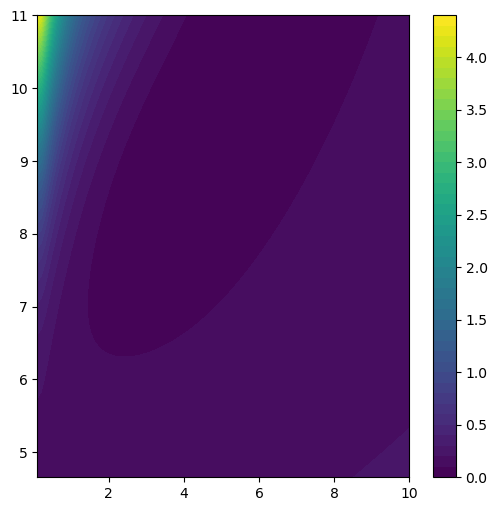

In [748]:
from matplotlib import cm
fig, ax = plt.subplots(figsize=(6,6))
plt.contourf(X, Y, loss_As, levels=50)#, extent=[np.min(b_As), np.max(b_As),
                   #         np.min(mu_As), np.max(mu_As)]);
#ax.set_aspect(1/100)
#fig.colorbar(cm.ScalarMappable(), ax=ax)
plt.colorbar()

# Sample from Loss

In [1036]:
def MCMC(original_params, L2_func, max_steps = 1000000, scale_factor=.1, beta=1):
    current_point = np.random.normal(original_params, 
                                     scale=original_params*scale_factor)
    current_point[current_point <= 0] = 0
    
    L2_samples = np.zeros(max_steps)
    point_samples = np.zeros((max_steps,current_point.shape[0]))
    L2_samples[0] = L2_func(*current_point)#[0][0]    
    point_samples[0, :] = current_point 
    for step in range(1, max_steps):
        next_point = np.random.normal(current_point, 
                                      scale=original_params*scale_factor)
        next_point[next_point <= 0] = 0       
        next_L2_sample = L2_func(*next_point)#[0][0]
        delta_E = next_L2_sample - L2_samples[step-1]        
        if min(1, np.exp(-beta * delta_E)) > np.random.rand():
            current_point = next_point
            L2_samples[step] = next_L2_sample
        else:
            L2_samples[step] = L2_samples[step-1]
        point_samples[step, :] = current_point 
    return L2_samples, point_samples

In [1096]:
init_A_params = np.array([1,1,1,1,1])#[params.b_A, params.mu_A, params.V_A, 
                          #params.K_AA, params.K_BA])*5#[1, 1, 1, 1, 1
A_loss_samples, A_param_samples = MCMC(init_A_params, 
                                       loss_A, 
                                       max_steps = 40000, 
                                       scale_factor=.1,
                                       beta=10000)

/tmp/ipykernel_1837/875758827.py:16: RuntimeWarning: overflow encountered in exp
  if min(1, np.exp(-beta * delta_E)) > np.random.rand():


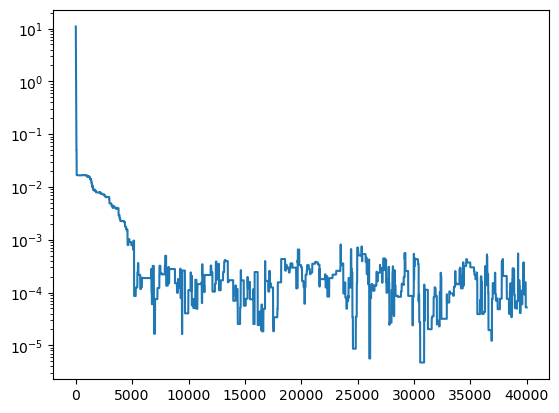

In [1097]:
plt.plot(A_loss_samples);plt.yscale('log')

In [1100]:
df_A = pd.DataFrame(A_param_samples[10000::,:], columns=params_A_name_list)
df_A.head()

,b_A,mu_A,V_A,K_AA,K_BA
0,0.0,0.089419,7.540927,5.079466,8.605203
1,0.0,0.089419,7.540927,5.079466,8.605203
2,0.0,0.089419,7.540927,5.079466,8.605203
3,0.0,0.089419,7.540927,5.079466,8.605203
4,0.0,0.089419,7.540927,5.079466,8.605203


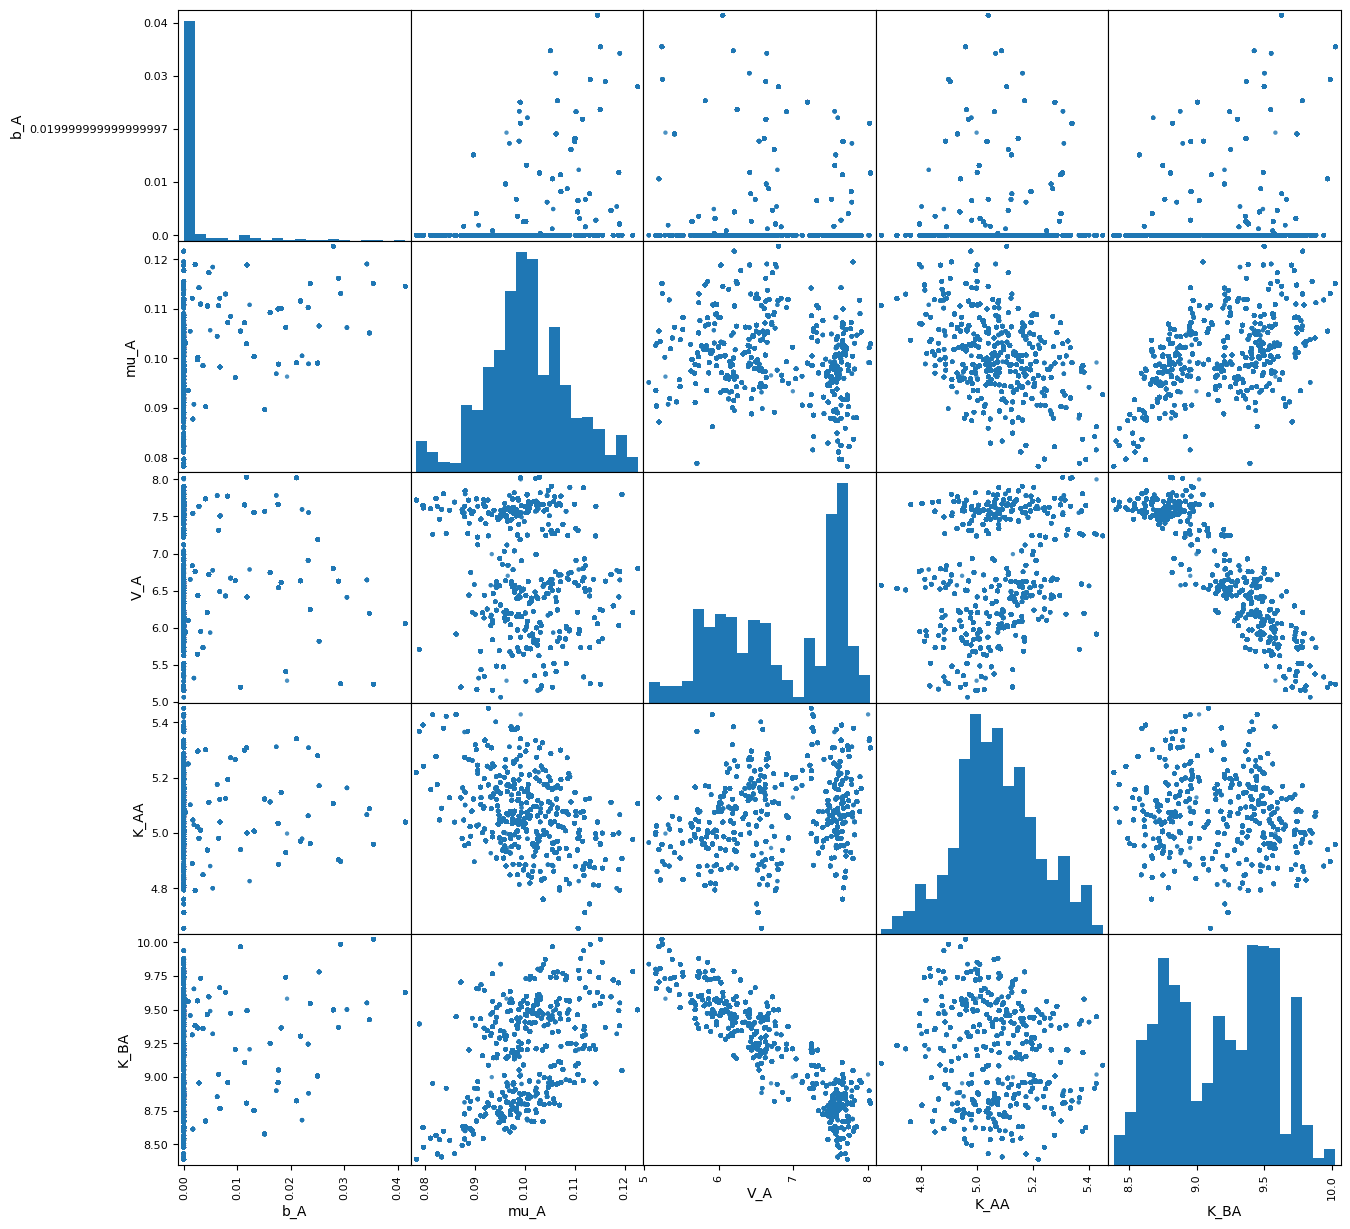

In [1101]:
axl = pd.plotting.scatter_matrix(df_A , figsize=(15, 15), marker='.',
hist_kwds={'bins': 20}, s=40, alpha=.8)
# for i, axs in enumerate(axl):
#     for j, ax in enumerate(axs):
#         if i != j:  # only the scatter plots
#             ax.set_xscale('log')
#             ax.set_yscale('log')

In [1089]:
params.b_A, params.mu_A, params.V_A, params.K_AA, params.K_BA

(0.001, 0.1, 5.0, 5.0, 10.0)

In [1106]:
def plot_single_minimum(original_params, L2_func, pca, component_index, steps = np.linspace(-1, 1, 200)):
    direction = pca.components_[component_index]
    test_points = directional_linspace(original_params, direction, steps)
    plt.plot(steps, [L2_func(*p) for p in  test_points], label=f"eigvec {component_index+1}")
    
def plot_minimums(original_params, L2_func, pca, steps = np.linspace(-1, 1, 200), per_plot=4, y_scale='log'):
    for i,direction in enumerate(pca.components_):
        plot_single_minimum(original_params, L2_func, pca, i, steps)
        if (i+1)%per_plot == 0 or (i+1) == len(pca.components_):
            original_L2 = L2_func(*original_params)
            plt.scatter(0, original_L2, marker='x')
            plt.yscale(y_scale);plt.legend();plt.grid();plt.show()

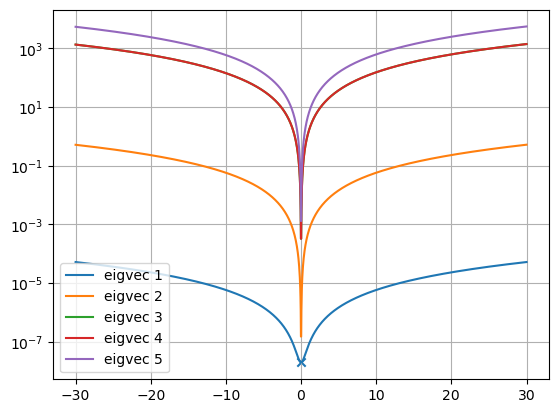

In [1116]:
class Object(object):
    pass
obj = Object()
original_A_params = np.array([params.b_A, params.mu_A, params.V_A, 
                             params.K_AA, params.K_BA])
obj.components_= original_A_params/np.sqrt(np.sum(original_A_params**2))

plot_minimums(original_A_params, 
              loss_A, obj, per_plot=5,
              y_scale='log',steps = np.linspace(-30, 30, 2000))

In [1117]:
from sklearn.decomposition import PCA
pca = PCA()
principalComponentsA = pca.fit_transform(A_param_samples[:, :])

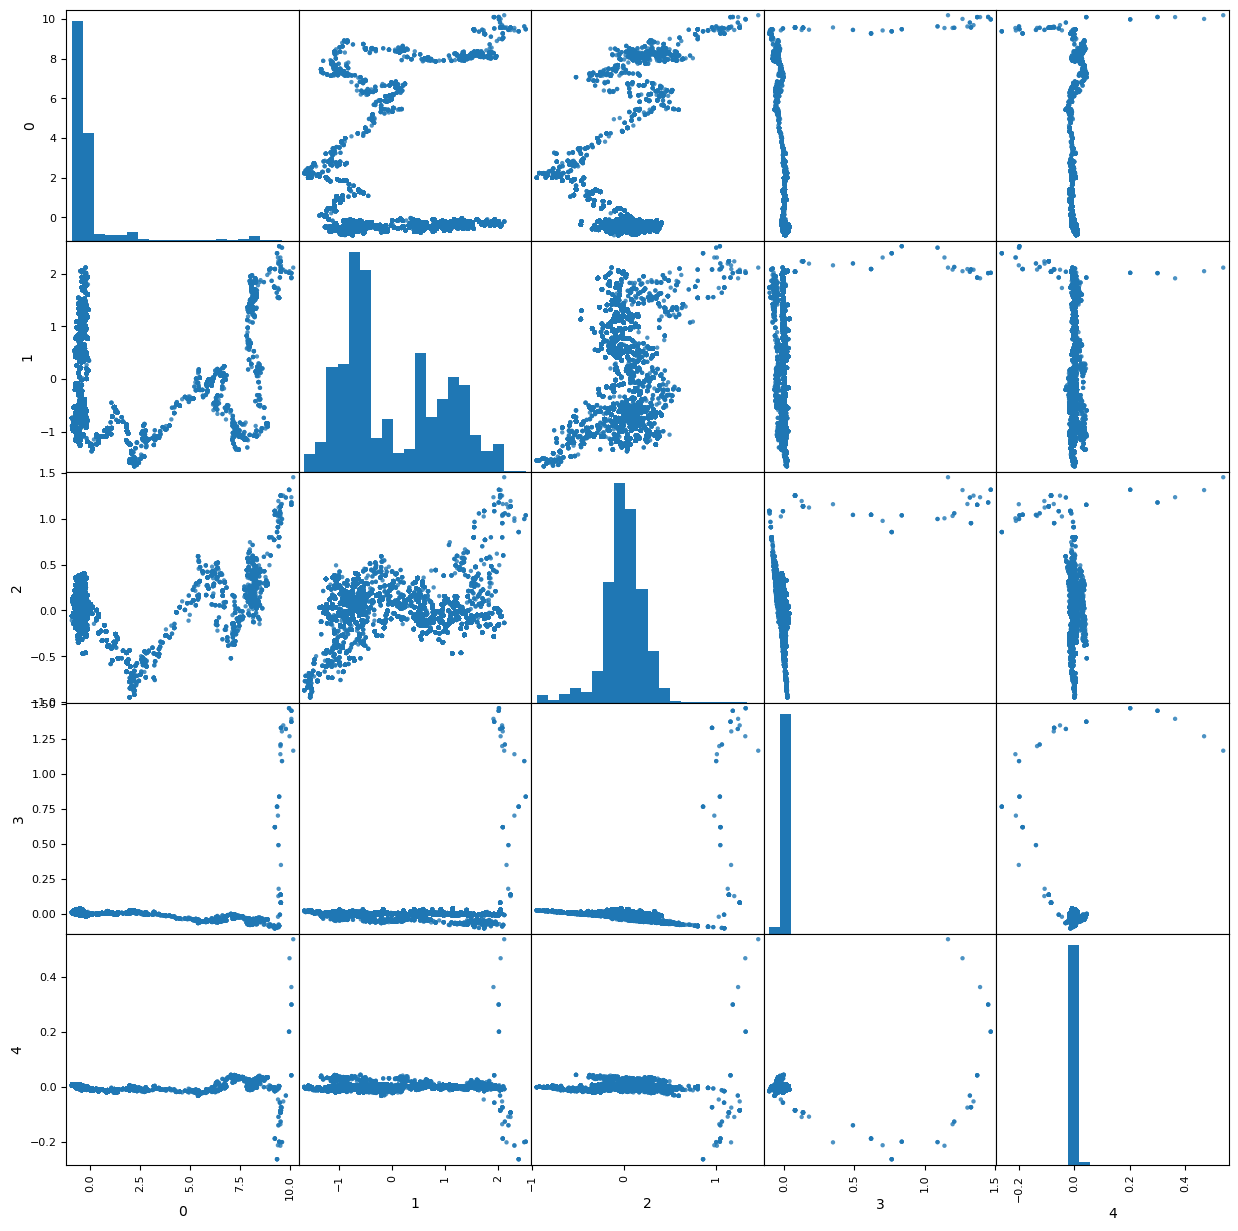

In [1118]:
df_A = pd.DataFrame(principalComponentsA[::,:])
axl = pd.plotting.scatter_matrix(df_A , figsize=(15, 15), marker='.',
hist_kwds={'bins': 20}, s=40, alpha=.8)

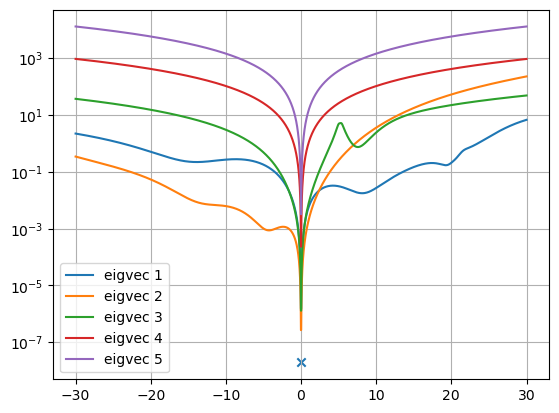

In [1119]:
plot_minimums(original_A_params, loss_A, pca, per_plot=5, y_scale='log',steps = np.linspace(-30, 30, 2000))

In [281]:
estimated_params = Struct(**estimated_params)
estimated_params_list = [estimated_params.b_A, estimated_params.mu_A, estimated_params.V_A, 
                         estimated_params.K_AA, estimated_params.K_AB, estimated_params.K_AC, 
                         estimated_params.b_B, estimated_params.mu_B, estimated_params.V_B, 
                         estimated_params.K_BA, estimated_params.K_BC, 
                         estimated_params.b_C, estimated_params.mu_C, estimated_params.V_C, 
                         estimated_params.K_CB, estimated_params.K_CC]
# estimated_params_log = [np.log(l) for l in estimated_params_list]
# print(loss(estimated_params_log))
print(loss(estimated_params_list))
print(loss(res.x))

0.01681721716132586
0.01681721716132586


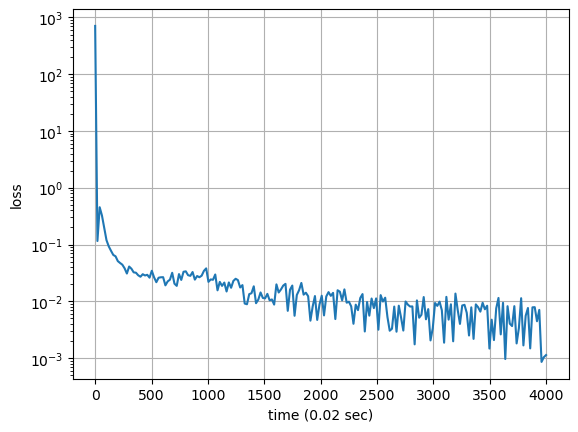

In [342]:
kinetics = create_circuit_3954(params["n"],params["b_A"], params["mu_A"], params["V_A"], 
                                       params["K_AA"], params["K_AB"], params["K_AC"],
                                       params["b_B"], params["mu_B"], params["V_B"], 
                                       params["K_BA"], params["K_BC"],
                                       params["b_C"], params["mu_C"], params["V_C"], 
                                       params["K_CB"], params["K_CC"])
def loss_by(A,B,C):
    x_slice = y_slice = slice(1,-1,1)
    diff_c = 1/(model.Δx*model.Δy)
    diffusion_A = diff_c * grad_diff(A)[x_slice,y_slice]
    diffusion_B = diff_c * grad_diff(B)[x_slice,y_slice]
    F_A, F_B, F_C = kinetics(A, B, C)
    dAdt = D_A*diffusion_A + F_A[x_slice,y_slice]
    dBdt = D_B*diffusion_B + F_B[x_slice,y_slice]
    dCdt = F_C[x_slice,y_slice]
    #print(np.mean(dAdt**2), np.mean(dBdt**2), np.mean(dCdt**2))
    return np.sqrt( np.mean(dAdt**2) + np.mean(dBdt**2) + np.mean(dCdt**2))
    
    
ts = np.linspace(0, solution.shape[0]*model.Δt, 200)
plt.plot(ts, [ loss_by(solution[i*1000,0, :].reshape((128,128)), 
                       solution[i*1000,1, :].reshape((128,128)), 
                       solution[i*1000,2, :].reshape((128,128)))
              for i, _ in enumerate(ts)])
plt.xlabel("time (0.02 sec)");plt.ylabel("loss")
plt.yscale('log');plt.grid();plt.show()



In [349]:
smooth_losses = [ loss_by(solution[i,0, :].reshape((128,128)), 
                       solution[i,1, :].reshape((128,128)), 
                       solution[i,2, :].reshape((128,128)))
              for i in range(200000-20000, 200000)]

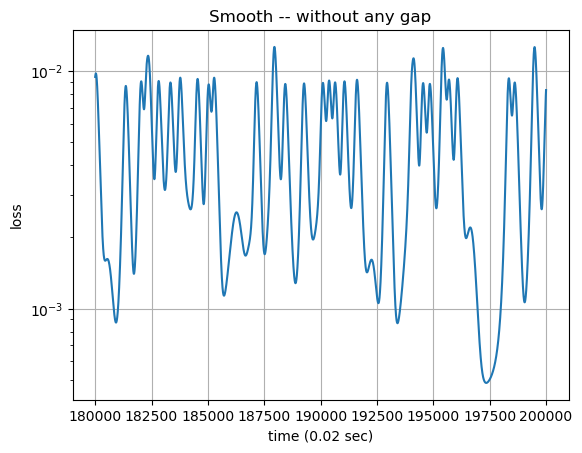

In [350]:
plt.plot(np.arange(200000-20000, 200000) + 1, smooth_losses)
plt.title("Smooth -- without any gap")
plt.xlabel("time (0.02 sec)");plt.ylabel("loss")
plt.yscale('log');plt.grid();plt.show()

In [351]:
smooth_losses2 = [ loss_by(solution[i,0, :].reshape((128,128)), 
                       solution[i,1, :].reshape((128,128)), 
                       solution[i,2, :].reshape((128,128)))
              for i in range(200000-40000, 200000)]

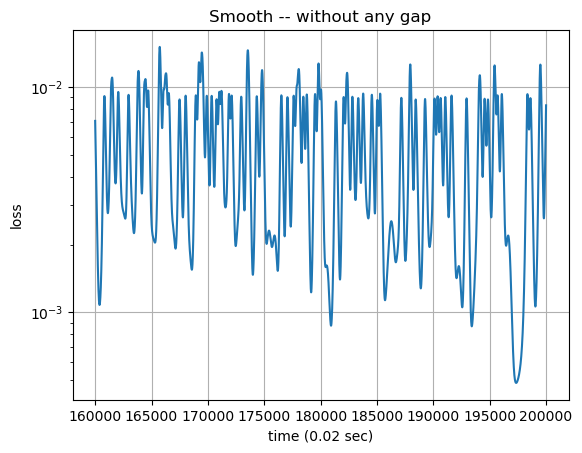

In [353]:
plt.plot(np.arange(200000-40000, 200000) + 1, smooth_losses2)
plt.title("Smooth -- without any gap")
plt.xlabel("time (0.02 sec)");plt.ylabel("loss")
plt.yscale('log');plt.grid();plt.show()

7.812322738360695e-05 0.0001398658536897556
4.2974085495055865e-05 6.759127670819233e-05
0.000255123423896029 0.008258864181479664

Absolut values - delta:0.0003762207367746919, Reaction diffusion:0.00037787282597540403, difference:-1.6520892007121282e-06
Root mean square values - delta:0.008260324969748052, Reaction diffusion:0.008260355056074963, difference:-3.008632691071933e-08


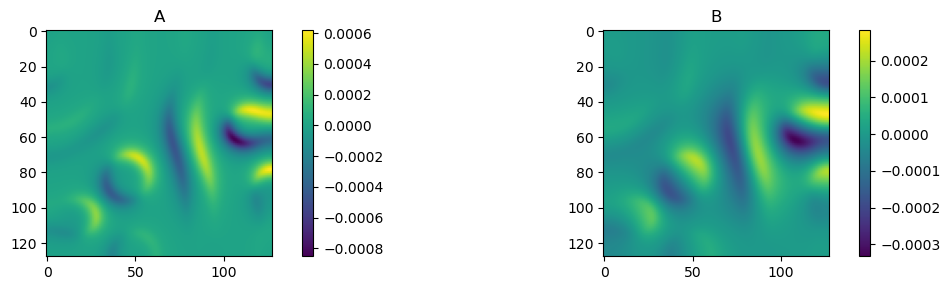

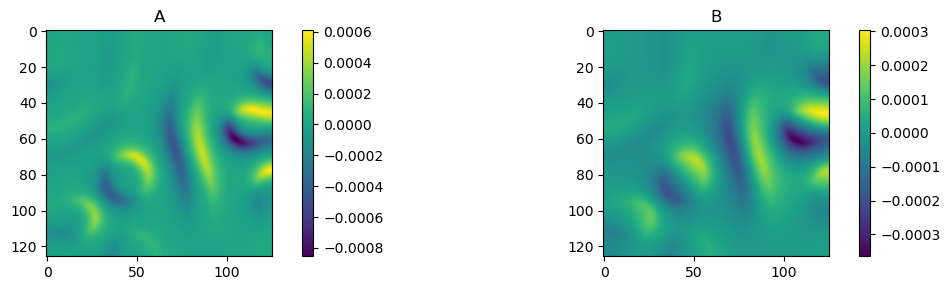

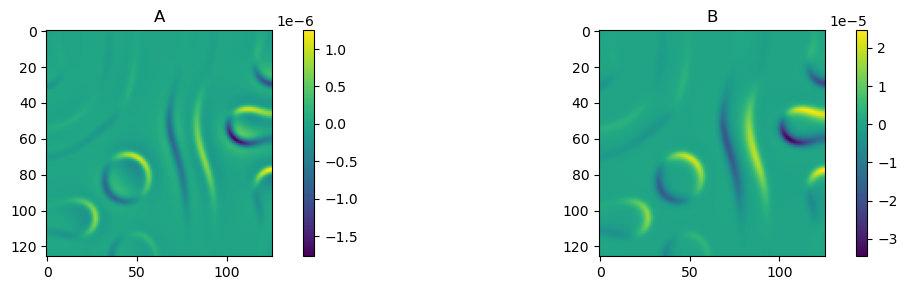

In [362]:

    
index = -1#200000-1
A_n = solution[index,0, :].reshape((128,128))
B_n = solution[index,1, :].reshape((128,128))
C_n = solution[index,2, :].reshape((128,128))

A_n_1 = solution[index-1,0, :].reshape((128,128))
B_n_1 = solution[index-1,1, :].reshape((128,128))
C_n_1 = solution[index-1,2, :].reshape((128,128))


#p(A_n, B_n, C_n)
#p(A_n_1, B_n_1, C_n_1)
print( np.mean(np.abs((A_n-A_n_1)[x_slice,y_slice]/model.Δt)),
      np.sqrt(np.mean( ((A_n-A_n_1)[x_slice,y_slice]/model.Δt) **2)))
print( np.mean(np.abs((B_n-B_n_1)[x_slice,y_slice]/model.Δt)),
      np.sqrt(np.mean( ((B_n-B_n_1)[x_slice,y_slice]/model.Δt) **2)))
print( np.mean(np.abs((C_n-C_n_1)[x_slice,y_slice]/model.Δt)),
      np.sqrt(np.mean( ((C_n-C_n_1)[x_slice,y_slice]/model.Δt) **2)))






x_slice = y_slice = slice(1,-1,1)
diff_c = 1/(model.Δx*model.Δy)
diffusion_A_n = diff_c * grad_diff(A_n)[x_slice,y_slice]
diffusion_B_n = diff_c * grad_diff(B_n)[x_slice,y_slice]

diffusion_A_n_1 = diff_c * grad_diff(A_n_1)[x_slice,y_slice]
diffusion_B_n_1 = diff_c * grad_diff(B_n_1)[x_slice,y_slice]

#p(diffusion_A_n, diffusion_B_n)
# p(diffusion_A_n_1, diffusion_B_n_1)

F_A_n, F_B_n, F_C_n = kinetics(A_n, B_n, C_n)
F_A_n_1, F_B_n_1, F_C_n_1 = kinetics(A_n_1, B_n_1, C_n_1)

F_A_n, F_B_n, F_C_n  = F_A_n[x_slice,y_slice], F_B_n[x_slice,y_slice], F_C_n[x_slice,y_slice]
F_A_n_1, F_B_n_1, F_C_n_1  = F_A_n_1[x_slice,y_slice], F_B_n_1[x_slice,y_slice], F_C_n_1[x_slice,y_slice]


dAdt_n = D_A*diffusion_A_n + F_A_n
dBdt_n = D_B*diffusion_B_n + F_B_n
#print(np.mean(dAdt_n**2))
#p(dAdt_n)
dAdt_n_1 = D_A*diffusion_A_n_1 + F_A_n_1
dBdt_n_1 = D_B*diffusion_B_n_1 + F_B_n_1

print()
mean_abs_delta = np.mean(np.abs((A_n-A_n_1)[x_slice,y_slice]/model.Δt)
            + np.abs((B_n-B_n_1)[x_slice,y_slice]/model.Δt)
            + np.abs((C_n-C_n_1)[x_slice,y_slice]/model.Δt))
mean_square_delta = np.sqrt( np.mean(((A_n-A_n_1)[x_slice,y_slice]/model.Δt) **2)  
     + np.mean(((B_n-B_n_1)[x_slice,y_slice]/model.Δt) **2)
     + np.mean(((C_n-C_n_1)[x_slice,y_slice]/model.Δt) **2))

mean_abs_ReDiff = np.mean(np.abs(D_A*diffusion_A_n_1 + F_A_n_1)
            + np.abs(D_B*diffusion_B_n_1 + F_B_n_1)
            + np.abs(F_C_n_1))
mean_square_ReDiff = np.sqrt( np.mean((D_A*diffusion_A_n_1 + F_A_n_1) **2)  
     + np.mean((D_B*diffusion_B_n_1 + F_B_n_1) **2)
     + np.mean((F_C_n_1) **2))
print(f"Absolut values - delta:{mean_abs_delta}, Reaction diffusion:{mean_abs_ReDiff}, difference:{mean_abs_delta-mean_abs_ReDiff}")
print(f"Root mean square values - delta:{mean_square_delta}, Reaction diffusion:{mean_square_ReDiff}, difference:{mean_square_delta-mean_square_ReDiff}")

p((A_n-A_n_1)/model.Δt, (B_n-B_n_1)/model.Δt)
p(D_A*diffusion_A_n_1 + F_A_n_1, D_B*diffusion_B_n_1 + F_B_n_1)
p(D_A*diffusion_A_n_1 + F_A_n_1 - (A_n-A_n_1)[x_slice,y_slice]/model.Δt, 
  D_B*diffusion_B_n_1 + F_B_n_1 - (B_n-B_n_1)[x_slice,y_slice]/model.Δt)

# p((D_A*diffusion_A_n + F_A_n  + D_A*diffusion_A_n_1 + F_A_n_1)/2 - (A_n-A_n_1)[x_slice,y_slice]/model.Δt, 
#    (D_B*diffusion_B_n + F_B_n + D_B*diffusion_B_n_1 + F_B_n_1)/2 - (B_n-B_n_1)[x_slice,y_slice]/model.Δt)

#p(D_A*diffusion_A_n, D_B*diffusion_B_n)
#p(diffusion_A_n_1, diffusion_B_n_1)
#p(F_A_n, F_B_n)
#p(F_A_n_1, F_B_n_1)
#p(model.Δt*dAdt_n, model.Δt*dBdt_n)
#p((A_n-A_n_1)[x_slice,y_slice], (B_n-B_n_1)[x_slice,y_slice])

#delta_A, delta_B = model.Δt*(dAdt_n+dAdt_n_1)/2, model.Δt*(dBdt_n+dBdt_n_1)/2
#p(delta_A , delta_B )
#p(delta_A-model.Δt*dAdt_n_1 , delta_B-model.Δt*dBdt_n_1 )
#p((A_n-A_n_1)[x_slice,y_slice], (B_n-B_n_1)[x_slice,y_slice])
#p(delta_A - (A_n-A_n_1)[x_slice,y_slice], delta_B - (B_n-B_n_1)[x_slice,y_slice])
#p(D_A*diffusion_A_n, D_B*diffusion_B_n)
#p(model.Δt*(dAdt_n+dAdt_n_1)/2, model.Δt*(dBdt_n+dBdt_n_1)/2)
#p(dAdt_n_1, dBdt_n_1)


In [816]:
with open(f"./inputs/solution_3.pkl", "rb") as f:
    (_, _, init_sol) = pickle.load(f)

In [825]:
bb_A, muu_A, VV_A , KK_AA, KK_BA = resA.x
bb_A, muu_A, VV_A , KK_AA, KK_BA

(0.0009995022253274594,
 0.09999803689419196,
 5.002812042444732,
 5.000153221170509,
 9.998243659549335)

In [826]:
bb_B, muu_B, VV_B , KK_AB, KK_CB = resB.x
bb_B, muu_B, VV_B , KK_AB, KK_CB

(0.9574735885623605,
 0.4958121019486826,
 19.971650126323052,
 4.998218133796583,
 48.21552107249067)

In [827]:
bb_C, muu_C, VV_C , KK_AC, KK_BC, KK_CC = resC.x
bb_C, muu_C, VV_C , KK_AC, KK_BC, KK_CC

(0.0, 0.0, 0.0, 15.757739534063607, 27.997433397205878, 48.21552107249067)

In [874]:

# kinetics = create_circuit_3954(params["n"],
#                                bb_A, muu_A, VV_A , KK_AA, KK_AB, KK_AC,
#                                bb_B, muu_B, VV_B , KK_BA, KK_BC,
#                                bb_C, muu_C, VV_C , KK_CB, KK_CC)

kinetics = create_circuit_3954(params["n"],
                               **estimated_params)

(A_init, B_init, C_init) = (init_sol[0, 0, :, :].flatten(),
                            init_sol[0, 1, :, :].flatten(),
                            init_sol[0, 2, :, :].flatten())
test_sol = model.integrate([A_init, B_init, C_init],kinetics, 4*5000, record_steps=1)

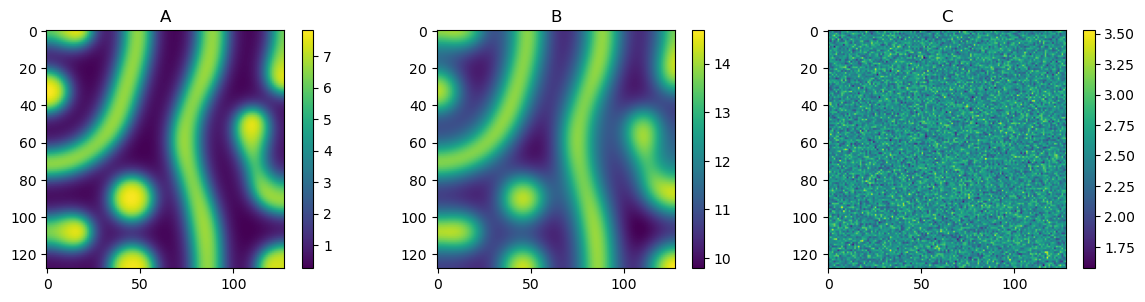

In [875]:
p(test_sol[-1,0, :].reshape((128,128)),
  test_sol[-1,1, :].reshape((128,128)),
  test_sol[-1,2, :].reshape((128,128)))

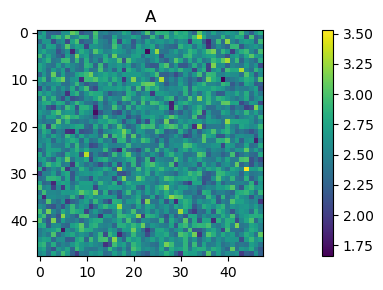

In [872]:
p(test_sol[-1,2, :].reshape((128,128))[40:-40, 40:-10])

In [869]:
estimated_params

{'b_A': 0.001000417473592467,
 'mu_A': 0.09999899238439601,
 'V_A': 5.00240578470991,
 'K_AA': 5.000126148509559,
 'K_AB': 4.999738133336735,
 'K_AC': 11.872402444825248,
 'b_B': 0.9938207944640343,
 'mu_B': 0.4993908837575317,
 'V_B': 19.995854358122532,
 'K_BA': 9.998507651991623,
 'K_BC': 21.278105342458353,
 'b_C': 0.0,
 'mu_C': 0.0,
 'V_C': 0.0,
 'K_CB': 72.84626057974457,
 'K_CC': 37.47312140106356}